# The Prediction Task
We will use the dataset gathered by our scraping script [Github](https://github.com/shkhaksar/book-classification) merged with two datasets from Kaggle. [Dataset1](https://www.kaggle.com/mdhamani/goodreads-books-100k) - [Dataset2](https://www.kaggle.com/sp1thas/book-depository-dataset)

The dataset contains book summaries for 200K books extracted from [Goodreads](https://www.goodreads.com/) and [BookDepository](https://www.bookdepository.com/) websites.

The classification goal is, given a new book, to predict the book belongs to which category of books.

#### Install dependencies

In [0]:
%pip install langdetect nltk

Python interpreter will be restarted.
Collecting langdetect
 Downloading langdetect-1.0.9.tar.gz (981 kB)
Requirement already satisfied: nltk in /local_disk0/.ephemeral_nfs/envs/pythonEnv-afb6a87d-e28a-4fa6-8e51-83bebfaa502d/lib/python3.8/site-packages (3.5)
Requirement already satisfied: six in /local_disk0/.ephemeral_nfs/envs/pythonEnv-afb6a87d-e28a-4fa6-8e51-83bebfaa502d/lib/python3.8/site-packages (from langdetect) (1.15.0)
Requirement already satisfied: joblib in /local_disk0/.ephemeral_nfs/envs/pythonEnv-afb6a87d-e28a-4fa6-8e51-83bebfaa502d/lib/python3.8/site-packages (from nltk) (0.17.0)
Requirement already satisfied: tqdm in /local_disk0/.ephemeral_nfs/envs/pythonEnv-afb6a87d-e28a-4fa6-8e51-83bebfaa502d/lib/python3.8/site-packages (from nltk) (4.50.2)
Requirement already satisfied: regex in /local_disk0/.ephemeral_nfs/envs/pythonEnv-afb6a87d-e28a-4fa6-8e51-83bebfaa502d/lib/python3.8/site-packages (from nltk) (2020.10.15)
Requirement already satisfied: click in /local_disk0/.ephemeral_nfs/envs/pythonEnv-afb6a87d-e28a-4fa6-8e51-83bebfaa502d/lib/python3.8/site-packages (from nltk) (7.1.2)
Building wheels for collected packages: langdetect
 Building wheel for langdetect (setup.py): started
 Building wheel for langdetect (setup.py): finished with status 'done'
 Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=af45b83dbb9383d02df219d4d219a52a44a4cdeb7e95d3da340f36cf864d1ee4
 Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect
Installing collected packages: langdetect
Successfully installed langdetect-1.0.9
Python interpreter will be restarted.

#### Import Useful packages

In [0]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import isnan

import numpy as np
from numpy import nan
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
RANDOM_SEED=100

## 1. Data Acquisition
This is the first step we need to accomplish before going any further. The dataset will be downloaded and loaded to DBFS.

##### Download the dataset to the local driver node's /tmp folder using wget

In [0]:
%sh wget -P /tmp https://github.com/shkhaksar/book-classification/raw/master/classifier/dataset.csv.bz2

--2021-07-09 17:43:36-- https://github.com/shkhaksar/book-classification/raw/master/classifier/dataset.csv.bz2
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shkhaksar/book-classification/master/classifier/dataset.csv.bz2 [following]
--2021-07-09 17:43:36-- https://raw.githubusercontent.com/shkhaksar/book-classification/master/classifier/dataset.csv.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52621279 (50M) [application/octet-stream]
Saving to: ‘/tmp/dataset.csv.bz2’

 0K .......... .......... .......... .......... .......... 0% 41.2M 1s
 50K .......... .......... .......... .......... .......... 0% 29.9M 1s
 100K .......... .......... .......... .......... .......... 0% 27.9M 2s
 150K .......... .......... .......... .......... .......... 0% 34.7M 2s
 200K .......... .......... .......... .......... .......... 0% 44.9M 1s
 250K .......... .......... .......... .......... .......... 0% 38.2M 1s
 300K .......... .......... .......... .......... .......... 0% 36.8M 1s
 350K .......... .......... .......... .......... .......... 0% 42.7M 1s
 400K .......... .......... .......... .......... .......... 0% 45.2M 1s
 450K .......... .......... .......... .......... .......... 0% 34.3M 1s
 500K .......... .......... .......... .......... .......... 1% 48.0M 1s
 550K .......... .......... .......... .......... .......... 1% 71.4M 1s
 600K .......... .......... .......... .......... .......... 1% 77.2M 1s
 650K .......... .......... .......... .......... .......... 1% 62.2M 1s
 700K .......... .......... .......... .......... .......... 1% 114M 1s
 750K .......... .......... .......... .......... .......... 1% 81.3M 1s
 800K .......... .......... .......... .......... .......... 1% 63.9M 1s
 850K .......... .......... .......... .......... .......... 1% 130M 1s
 900K .......... .......... .......... .......... .......... 1% 74.7M 1s
 950K .......... .......... .......... .......... .......... 1% 63.6M 1s
 1000K .......... .......... .......... .......... .......... 2% 128M 1s
 1050K .......... .......... .......... .......... .......... 2% 71.4M 1s
 1100K .......... .......... .......... .......... .......... 2% 76.6M 1s
 1150K .......... .......... .......... .......... .......... 2% 114M 1s
 1200K .......... .......... .......... .......... .......... 2% 85.6M 1s
 1250K .......... .......... .......... .......... .......... 2% 136M 1s
 1300K .......... .......... .......... .......... .......... 2% 121M 1s
 1350K .......... .......... .......... .......... .......... 2% 105M 1s
 1400K .......... .......... .......... .......... .......... 2% 136M 1s
 1450K .......... .......... .......... .......... .......... 2% 89.1M 1s
 1500K .......... .......... .......... .......... .......... 3% 128M 1s
 1550K .......... .......... .......... .......... .......... 3% 103M 1s
 1600K .......... .......... .......... .......... .......... 3% 119M 1s
 1650K .......... .......... .......... .......... .......... 3% 92.8M 1s
 1700K .......... .......... .......... .......... .......... 3% 113M 1s
 1750K .......... .......... .......... .......... .......... 3% 116M 1s
 1800K .......... .......... .......... .......... .......... 3% 117M 1s
 1850K .......... .......... .......... .......... .......... 3% 99.7M 1s
 1900K .......... .......... .......... .......... .......... 3% 137M 1s
 1950K .......... .......... .......... .......... .......... 3% 110M 1s
 2000K .......... .......... .......... .......... .......... 3% 152M 1s
 2050K .......... .......... .......... .......... .......... 4% 162M 1s
 2100K .......... .......... .......... .......... ..

In [0]:
%fs ls file:/tmp/

path,name,size
file:/tmp/rstudio-rsession/,rstudio-rsession/,4096
file:/tmp/.XIM-unix/,.XIM-unix/,4096
file:/tmp/spark-root-org.apache.spark.deploy.master.Master-1.pid,spark-root-org.apache.spark.deploy.master.Master-1.pid,4
file:/tmp/custom-spark.conf,custom-spark.conf,215
file:/tmp/RtmpVNEuRU/,RtmpVNEuRU/,4096
file:/tmp/chauffeur-daemon.pid,chauffeur-daemon.pid,4
file:/tmp/hsperfdata_root/,hsperfdata_root/,4096
file:/tmp/.X11-unix/,.X11-unix/,4096
file:/tmp/systemd-private-b0e30484c34740c6aa17904f39279cad-systemd-resolved.service-Pmea6F/,systemd-private-b0e30484c34740c6aa17904f39279cad-systemd-resolved.service-Pmea6F/,4096
file:/tmp/driver-daemon-params,driver-daemon-params,19


##### Move the file from local driver node's file system to DBFS (in the directory we created)

In [0]:
%fs mkdirs book-classifier/datasets/

res1: Boolean = true

In [0]:
dbutils.fs.mv("file:/tmp/dataset.csv.bz2", "dbfs:/book-classifier/datasets/dataset.csv.bz2")
#dbutils.fs.rm("dbfs:/book_classifier/datasets/dataset.csv.bz2")                remove csv command

Out[4]: True

##### Read dataset file into a Spark Dataframe

In [0]:
book_df = spark.read.load("dbfs:/book-classifier/datasets/dataset.csv.bz2", 
                           format="csv",quote="\"",escape="\"",
                           sep=",", multiLine=True,
                           inferSchema="true", 
                           header="true")

##### Dataset Shape and Schema
The dataset contains 200K+ records of Books; each record, is represented by the following set of 3 columns:

- Title: The books title, although it's not being used in this task.
- Description: A brief description about the book.
- Category: A category of books, consists of 34 distinct categories.

##### Check the shape of the loaded dataset, i.e., number of rows and columns

In [0]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(book_df.count(), len(book_df.columns)))

The shape of the dataset is 224897 rows by 3 columns

##### Print out the schema of the loaded dataset

In [0]:
book_df.printSchema()

root
-- Title: string (nullable = true)
-- Category: string (nullable = true)
-- Description: string (nullable = true)

We drop `Title` column to decrease memory footprint of our training task.

In [0]:
book_df = book_df.drop('Title')

##### Display the first 5 rows of the dataset

In [0]:
book_df.show(n=5,truncate=True)

+----------+--------------------+
 Category| Description|
+----------+--------------------+
 History|Reveals that seve...|
 Art|Fashion Sourceboo...|
 History|The seminal histo...|
 History|"All-American Ana...|
Nonfiction|Aujourd’hui, l’oi...|
+----------+--------------------+
only showing top 5 rows

##### Check for duplicated Books

In [0]:
print("The total number of duplicated books are {:d} out of {:d}".format(book_df.count() - book_df.dropDuplicates(['Description']).count(), book_df.count()))   

The total number of duplicated books are 25251 out of 224897

##### Drop duplicated books

In [0]:
book_df =  book_df.dropDuplicates(['Description'])
print("The total number of unique books is: {:d}".format(book_df.count()))

The total number of unique books is: 199646

##### Check for any missing values

In [0]:
for c in book_df.columns:
  print("N. of missing values of column `{:s}` = {:d}".format(c, book_df.where(col(c).isNull() | isnan(col(c)) | (col(c) == " ")).count()))

N. of missing values of column `Category` = 15953
N. of missing values of column `Description` = 2

##### Remove the missing values

In [0]:
book_df = book_df.na.drop()
for c in book_df.columns:
    book_df = book_df.filter(~col(c).isNull()).filter(~isnan(col(c))).filter(~(col(c) == " ")) #drop nan values too

In [0]:
for c in book_df.columns:
  print("N. of missing values of column `{:s}` = {:d}".format(c, book_df.where(col(c).isNull() | isnan(col(c)) | (col(c) == " ")).count()))

N. of missing values of column `Category` = 0
N. of missing values of column `Description` = 0

##### Now we briefly check our categories

In [0]:
book_df.groupBy("Category").count().orderBy("Count",ascending=False).show(30,truncate=False)

+------------------+-----+
Category |count|
+------------------+-----+
Biography |19782|
Nonfiction |18961|
Fiction |10994|
Young Adult |10593|
Romance |10141|
Art |9290 |
Science Fiction |9245 |
Graphic Novels |8888 |
Mystery |6907 |
History |6608 |
Horror |6585 |
Science |6573 |
Classic |6566 |
Fantasy |6493 |
Memoir |6347 |
Cookbooks |6282 |
Thriller |6181 |
Historical Fiction|6023 |
Children & Comics |5726 |
Self Help |5679 |
Business & Travel |5307 |
Christian |4522 |
+------------------+-----+

##### Let's see how many different categories do we have in our dataset

In [0]:
n_cats = book_df.groupby("Category").count().count()
print("Total Number of categories in our database {}".format(n_cats))

Total Number of categories in our database 22

## 2. Data Exploration/Pre-processing

#### Detecting text languages
To train only based on english books, all records which content is not in engish needs to be removed.

We detect language by using [langdetect](https://github.com/Mimino666/langdetect). The result will be a new dataframe with an aditional column `lang`. Finally, we will remove rows not containing `en`.

Below you can view the helper function for detecting languages:

In [0]:
def language_detect(df, description_col="Description"):
  from langdetect import detect
  
  def detector(text)->str:
    try:
      return detect(text)
    except:
      return None
  
  detect_udf = udf(lambda desc: detector(desc), StringType())
  detected_df = df.withColumn("lang", detect_udf(description_col)).cache()
  detected_df.show(10)
  
  return detected_df

In [0]:
book_df = language_detect(book_df)

+------------------+--------------------+----+
 Category| Description|lang|
+------------------+--------------------+----+
 Fantasy|
 ,
 ,In the ...| en|
 Mystery|
 , Once upon a ...| en|
 Nonfiction|
 ,A bestselling...| en|
 Science|
 ,A pop science...| en|
 Romance|
 ,A ruby pendan...| en|
 Romance|
 ,The Inferno C...| en|
 Christian|
 ,Winner of the...| en|
 Young Adult| 
 
 
 
 ...| en|
 Young Adult| After...| en|
Historical Fiction| Miranda Ellis i...| en|
+------------------+--------------------+----+
only showing top 10 rows

Now let's see how many records have `en` as their language.

In [0]:
book_df.groupBy("lang").count().orderBy("Count",ascending=False).show()

+----+------+
lang| count|
+----+------+
 en|172309|
 es| 2454|
 de| 1167|
 fr| 931|
 pt| 669|
 pl| 558|
 it| 532|
 nl| 503|
 id| 485|
 ja| 411|
 da| 383|
 tr| 363|
 ar| 336|
 sv| 335|
 ro| 334|
 fi| 266|
 cs| 168|
 vi| 162|
 no| 137|
 hu| 133|
+----+------+
only showing top 20 rows

Now our dataset is tagged in `lang` column. we can now safely remove rows without `en`tag, then drop `lang` column.

In [0]:
book_df = book_df.filter((col("lang") == "en")).select(["Description","Category"])

In [0]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(book_df.count(), len(book_df.columns)))

The shape of the dataset is 172309 rows by 2 columns

#### Data Visualization
It is a good time to visualize our data. We use matplotlib library to get a sense of possible insights.

In [0]:
genre_list = [ # this is a refrence for all of possible genres
'Art','Biography','Business & Travel','Children & Comics','Christian','Classics','Cookbooks','Fantasy', 'Science Fiction','Nonfiction','Historical Fiction','Fiction','Graphic Novels','History','Horror','Memoir','Mystery', 'Romance','Science', 'Self Help','Thriller','Young Adult']

In [0]:
p_book_df = book_df.toPandas()

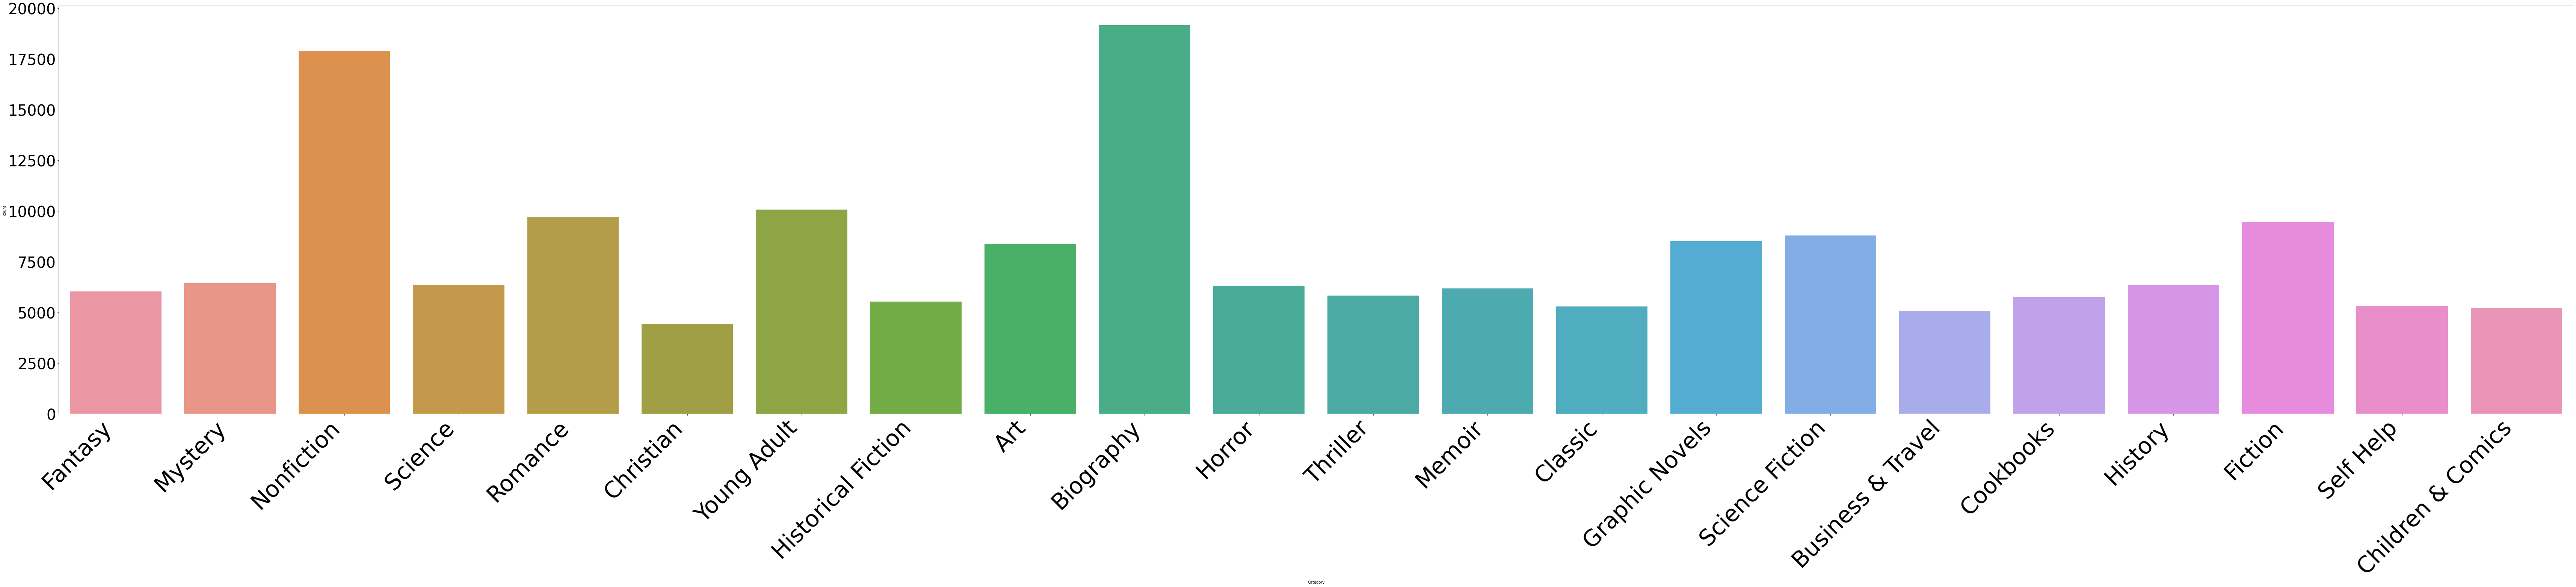

In [0]:
fig, axe = plt.subplots(1, 1, figsize=(120,20))

ax = sns.countplot(p_book_df["Category"], ax=axe)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(40)


#### We want to have a look a few description and category pairs.

In [0]:
def print_plot(index):
    example = p_book_df[p_book_df.index == index][['Description', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print("---------")
        print('Category:', example[1])
        
print_plot(10)
print("\n")
print_plot(100)

From bestselling author and host of HBO's ,Real Time,, Bill Maher's new book of political riffs serves up a savagely funny set of rules for preserving sanity in an insane world ,A follow-up to the ,New York Times, bestselling ,The New Rules,, ,The, New ,New Rules, delivers a series of hilarious, intelligent rants on everything from same-sex marriage to healthcare, from Republican agendas to celebrity meltdowns, with all the razor-sharp insight that has made Bill Maher one of the most influential comedic voices shaping the political debate today. With another presidential campaign on the horizon and a stellar set of real- life characters to have fun with-"New Rule: If Charlie Sheen's home life means he can't have a TV show, then I say Newt Gingrich can't be president"-this enlightening and important book may be the best thing you pretend to read all year.
---------
Category: Nonfiction


A unique testimony to modern literature's most celebrated and enduring marriage.
---------
Category: Biography

#### Text Pre-processing and cleaning

As preliminary steps of any NLP task, at least the following pipeline must be executed first:

- Text cleaning:
   - Case normalization (lower) -> convert all text to lower case;
   - Filter out leading and trailing whitespaces (trim);
   - Filter out punctuation symbols (regexp_replace);
   - Filter out newlines and tabs (regexp_replace);
   - Filter out any internal extra whitespace resulting from the step above (regexp_replace + trim).

- Tokenization (Tokenizer): splitting raw text into a list of individual tokens (i.e., words), typically using whitespace as delimiter
- Stopwords removal (StopWordsRemover): removing so-called stopwords, namely words that do not contribute to the deeper meaning of the document like "the", "a", "me", etc.
- Stemming (SnowballStemmer): reducing each word to its root or base. For example "fishing", "fished", "fisher" all reduce to the stem "fish".

In [0]:
def clean_text(df, column_name="Description"):
    """ 
    This function takes the raw text data and applies a standard NLP preprocessing pipeline consisting of the following steps:
      - Text cleaning
      - Tokenization
      - Stopwords removal
      - Stemming (Snowball stemmer)

    parameter: dataframe
    returns: the input dataframe along with the `cleaned_content` column as the results of the NLP preprocessing pipeline
    """
    
    from pyspark.sql.functions import udf, col, lower, trim, regexp_replace
    from pyspark.ml.feature import Tokenizer, StopWordsRemover
    from nltk.stem.snowball import SnowballStemmer # BE SURE NLTK IS INSTALLED ON THE CLUSTER

    # Text preprocessing pipeline
    print("***** Text Preprocessing Pipeline *****\n")

    # 1. Text cleaning
    print("# 1. Text Cleaning\n")
    # 1.a Case normalization
    print("1.a Case normalization:")
    lower_case_df = df.withColumn(column_name,lower(col(column_name)).alias(column_name))
    lower_case_df.show(10)
    
    # 1.b Trimming
    print("1.b Trimming:")
    trimmed_df = lower_case_df.withColumn(column_name,trim(col(column_name)).alias(column_name))
    trimmed_df.show(10)
    # 1.c Filter out punctuation symbols
    print("1.c Filter out punctuation:")
    no_punct_df = trimmed_df.withColumn(column_name,(regexp_replace(col(column_name), "[^a-zA-Z\\s]", "")).alias(column_name))
    no_punct_df.show(10)
    # 1.d Filter out any new line
    print("1.d Filter out any new line or tab:")
    no_new_line_df = no_punct_df.withColumn(column_name,trim(regexp_replace(col(column_name), "\s+", " ")).alias(column_name))
    no_new_line_df.show(10)
    # 1.d Filter out any internal extra whitespace
    print("1.d Filter out extra whitespaces:")
    cleaned_df = no_new_line_df.withColumn(column_name,trim(regexp_replace(col(column_name), " +", " ")).alias(column_name))
    cleaned_df.show(10)

    # 2. Tokenization (split text into tokens)
    print("# 2. Tokenization:")
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_df).cache()
    tokens_df.show(10)

    # 3. Stopwords removal
    print("# 3. Stopwords removal:")
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    terms_df = stopwords_remover.transform(tokens_df).cache()
    terms_df.show(10)

    # 4. Stemming (Snowball stemmer)
    print("# 4. Stemming:")
    stemmer = SnowballStemmer(language="english")
    stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
    terms_stemmed_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms")).cache()
    terms_stemmed_df.show(10)
    
    return terms_stemmed_df

In [0]:
clean_book_df = clean_text(book_df,"Description")

***** Text Preprocessing Pipeline *****

# 1. Text Cleaning

1.a Case normalization:
+--------------------+------------------+
 Description| Category|
+--------------------+------------------+

 ,
 ,in the ...| Fantasy|

 , once upon a ...| Mystery|

 ,a bestselling...| Nonfiction|

 ,a pop science...| Science|

 ,a ruby pendan...| Romance|

 ,the inferno c...| Romance|

 ,winner of the...| Christian|
 
 
 
 
 ...| Young Adult|
 after...| Young Adult|
 miranda ellis i...|Historical Fiction|
+--------------------+------------------+
only showing top 10 rows

1.b Trimming:
+--------------------+------------------+
 Description| Category|
+--------------------+------------------+

 ,
 ,in the ...| Fantasy|

 , once upon a ...| Mystery|

 ,a bestselling...| Nonfiction|

 ,a pop science...| Science|

 ,a ruby pendan...| Romance|

 ,the inferno c...| Romance|

 ,winner of the...| Christian|

 
 
 
 
...| Young Adult|
after years on th...| Young Adult|
miranda ellis is ...|Historical Fiction|
+--------------------+------------------+
only showing top 10 rows

1.c Filter out punctuation:
+--------------------+------------------+
 Description| Category|
+--------------------+------------------+

 
 in the la...| Fantasy|

 once upon a t...| Mystery|

 a bestselling ...| Nonfiction|

 a pop science ...| Science|

 a ruby pendant...| Romance|

 the inferno cl...| Romance|

 winner of the ...| Christian|

 
 
 
 
...| Young Adult|
after years on th...| Young Adult|
miranda ellis is ...|Historical Fiction|
+--------------------+------------------+
only showing top 10 rows

1.d Filter out any new line or tab:
+--------------------+------------------+
 Description| Category|
+--------------------+------------------+
in the latest nov...| Fantasy|
once upon a time ...| Mystery|
a bestselling cla...| Nonfiction|
a pop science loo...| Science|
a ruby pendant st...| Romance|
the inferno club ...| Romance|
winner of the out...| Christian|
this is a young a...| Young Adult|
after years on th...| Young Adult|
miranda ellis is ...|Historical Fiction|
+--------------------+------------------+
only showing top 10 rows

1.d Filter out extra whitespaces:
+--------------------+------------------+
 Description| Category|
+--------------------+------------------+
in the latest nov...| Fantasy|
once upon a time ...| Mystery|
a bestselling cla...| Nonfiction|
a pop science loo...| Science|
a ruby pendant st...| Romance|
the inferno club ...| Romance|
winner of the out...| Christian|
this is a young a...| Young Adult|
after years on th...| Young Adult|
miranda ellis is ...|Historical Fiction|
+--------------------+------------------+
only showing top 10 rows

# 2. Tokenization:
+--------------------+------------------+--------------------+
 Description| Category| tokens|
+--------------------+------------------+--------------------+
in the latest nov...| Fantasy|[in, the, latest,...|
once upon a time ...| Mystery|[once, upon, a, t...|
a bestselling cla...| Nonfiction|[a, bestselling, ...|
a pop science loo...| Science|[a, pop, science,...|
a ruby pendant st...| Romance|[a, ruby, pendant...|
the inferno club ...| Romance|[the, inferno, cl...|
winner of the out...| Christian|[winner, of, the,...|
this is a young a...| Young Adult|[this, is, a, you...|
after years on th...| Young Adult|[after, years, on...|
miranda ellis is ...|Historical Fiction|[miranda, ellis, ...|
+--------------------+------------------+--------------------+
only showing top 10 rows

# 3. Stopwords removal:
+--------------------+------------------+--------------------+--------------------+
 Description| Category| tokens| terms|
+--------------------+------------------+--------------------+--------------------+
in the latest nov...| Fantasy|[in, the, latest,...|[latest, novel, u...|
once upon a time ...| Mystery|[once, upon, a, t...|[upon, time, perf...|
a bestselling cla...| Nonfiction|[a, bestselling, ...|[bestselling, cla...|
a pop science loo...| Science|[a, pop, science,...|[pop, scienc

We rename column `terms_stemmed` to `terms` for convenience:

In [0]:
clean_book_df = clean_book_df.select(['Category','Description','terms_stemmed']).withColumnRenamed('terms_stemmed','terms')

## 3. Learning Pipeline
##### - Logistic Regression (TF-IDF - ParamGrid - K-Flod Cross Validation)
##### - Naive Bayes Model (TF-IDF - ParamGrid - K-Flod Cross Validation)
##### - Random Forest (TF-IDF - ParamGrid - K-Flod Cross Validation)

In [0]:
VOCAB_SIZE = 20000 # number of words to be retained as vocabulary
MIN_DOC_FREQ = 10 # minimum number of documents a word has to appear in to be included in the vocabulary
N_FEATURES = 20000 # default embedding vector size (if HashingTF or, later, Word2Vec are used)

As our database is (Almost) balanced we will use Simple Random Spliting to split our train and testset.

In [0]:
train_df, test_df = clean_book_df.randomSplit([0.7, 0.3], seed=RANDOM_SEED)
print("Training Set count: {}".format(train_df.count()))
print("Test Set count: {}".format(test_df.count()))

Training Set count: 120619
Test Set count: 51690

In [0]:

def logistic_regression_pipeline(df, terms_feature_col="terms", label_col="Category"):
  
  from pyspark.ml.feature import StringIndexer,HashingTF, IDF
  from pyspark.ml.classification import LogisticRegression
  from pyspark.ml import Pipeline
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator
  from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
    
  
  label_string_idx = StringIndexer(inputCol=label_col, outputCol = "label")     #categories => numebers

  hashingTF = HashingTF(inputCol=terms_feature_col, outputCol="tf_features", numFeatures=N_FEATURES)
  idf = IDF(inputCol="tf_features", outputCol="features")
    
  lr = LogisticRegression(maxIter=20)

  pipeline = Pipeline(stages=[label_string_idx, hashingTF, idf, lr])
    
    
  # Create ParamGrid for Cross Validation
  paramGrid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
                 .addGrid(lr.elasticNetParam, [0.0, 0.1]) # Elastic Net Parameter (Ridge = 0)
                 .build())

  # Create 5-fold CrossValidator
  cv = CrossValidator(estimator=pipeline, \
                        estimatorParamMaps=paramGrid, \
                        evaluator=MulticlassClassificationEvaluator(), \
                        numFolds=5, collectSubModels=True)
    
  cv_model = cv.fit(df)
    
  return cv_model

In [0]:
cv_model = logistic_regression_pipeline(train_df ,terms_feature_col="terms", label_col="Category")

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
def lr_model_evaluation(cv_models, test_dataset):
  
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator
  
  # Make predictions.
  predictions = cv_models.transform(test_dataset)
  predictions.filter(predictions['prediction'] == 0) \
    .select("Description","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)
  
  evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
  accuracy= evaluator.evaluate(predictions)
  
  print("""****Test evaluation*****""")
  print("Test Accuracy = %g "%(accuracy))
  print("""****Test evaluation*****""")
  print("-----------")
  
  lrModel = cv_models.bestModel.stages[2]
  print(lrModel)  # summary only
     

In [0]:
lr_model_evaluation(cv_model,test_df)

+------------------------------+----------+------------------------------+-----+----------+
 Description| Category| probability|label|prediction|
+------------------------------+----------+------------------------------+-----+----------+
autobiography of a yogi tel...| Biography|[0.9984838503291564,6.71565...| 0.0| 0.0|
before barbara walters befo...| Biography|[0.9902583758062555,0.00223...| 0.0| 0.0|
new york times bestseller f...| Biography|[0.9884151696984247,0.00484...| 0.0| 0.0|
this unique edition brings ...|Nonfiction|[0.9884013714141533,0.00161...| 1.0| 0.0|
amazing grace tells the sto...| Biography|[0.9851895112166011,0.00248...| 0.0| 0.0|
in this frank and informati...| Biography|[0.9820672817042738,0.00388...| 0.0| 0.0|
a chance encounter in spain...| Biography|[0.9819690673103605,1.90439...| 0.0| 0.0|
winner of the audie award f...| Biography|[0.9819217394010623,9.07307...| 0.0| 0.0|
now a major motion picture ...| Biography|[0.9767578176327831,9.83609...| 0.0| 0.0|
the untold story of the wom...| Biography|[0.9735847078760473,0.00563...| 0.0| 0.0|
+------------------------------+----------+------------------------------+-----+----------+
only showing top 10 rows

****Test evaluation*****
Test Accuracy = 0.489036 
****Test evaluation*****
-----------
IDFModel: uid=IDF_e37be8dfa4d0, numDocs=137874, numFeatures=20000

In [0]:
lr_model_evaluation(cv_model,train_df)

+------------------------------+---------+------------------------------+-----+----------+
 Description| Category| probability|label|prediction|
+------------------------------+---------+------------------------------+-----+----------+
the spellbinding story of c...|Biography|[0.9960286927632201,7.51463...| 0.0| 0.0|
although it was still too d...|Biography|[0.9957825363521274,5.99691...| 0.0| 0.0|
national book critics circl...|Biography|[0.9953201230739724,4.87416...| 0.0| 0.0|
the story of my boyhood and...|Biography|[0.995078142580348,0.003219...| 0.0| 0.0|
elspeth huxley who died in ...|Biography|[0.9945846309108932,0.00136...| 0.0| 0.0|
the first major biography o...|Biography|[0.9943041819566336,0.00121...| 0.0| 0.0|
the sensational biography o...|Biography|[0.9931490041936227,8.46066...| 0.0| 0.0|
the first major biography o...|Biography|[0.9924381416207139,8.41894...| 0.0| 0.0|
congressman john lewis has ...|Biography|[0.9917022396985903,0.00175...| 0.0| 0.0|
in this eagerly anticipated...|Biography|[0.9914627255654174,6.12372...| 0.0| 0.0|
+------------------------------+---------+------------------------------+-----+----------+
only showing top 10 rows

****Test evaluation*****
Test Accuracy = 0.685002 
****Test evaluation*****
-----------
IDFModel: uid=IDF_e37be8dfa4d0, numDocs=137874, numFeatures=20000

### Naive Bayes Model

In [0]:
def nb_pipeline(df, terms_feature_col="terms", label_col="Category"):
  
  from pyspark.ml.feature import StringIndexer, HashingTF, IDF
  from pyspark.ml import Pipeline
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator
  from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
  from pyspark.ml.classification import NaiveBayes
  
  label_string_idx = StringIndexer(inputCol=label_col, outputCol = "label")     #categories => numebers

  hashingTF = HashingTF(inputCol=terms_feature_col, outputCol="tf_features", numFeatures=N_FEATURES)
  idf = IDF(inputCol="tf_features", outputCol="features")
  
  nb = NaiveBayes(smoothing=1)

  pipeline = Pipeline(stages=[label_string_idx, hashingTF, idf, nb])

  paramGrid = (ParamGridBuilder()
                 .addGrid(nb.smoothing, [0.0, 0.5, 1.0])
                 .build())

  # Create 5-fold CrossValidator
  cv = CrossValidator(estimator=pipeline, \
                        estimatorParamMaps=paramGrid, \
                        evaluator=MulticlassClassificationEvaluator(), \
                        numFolds=5, collectSubModels=True)
    
  cv_model = cv.fit(df)
    
  return cv_model

In [0]:
nb_model = nb_pipeline(train_df,terms_feature_col="terms", label_col="Category")

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
def nb_model_evaluation(nb_model,test_dataset):
  
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator
  
  # Make predictions.
  predictions = nb_model.transform(test_dataset)
  predictions.filter(predictions['prediction'] == 0) \
    .select("Description","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)
  
  evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
  accuracy = evaluator.evaluate(predictions)
  print("Test Accuracy = %g "%(accuracy))
  print("-----------")

  nb_model = nb_model.bestModel.stages[2]
  print(nb_model)  # summary only
  

In [0]:
nb_model_evaluation(nb_model,test_df)

+------------------------------+----------+------------------------------+-----+----------+
 Description| Category| probability|label|prediction|
+------------------------------+----------+------------------------------+-----+----------+
buried memories katie beers...|Nonfiction|[1.0,8.623214360379054E-17,...| 1.0| 0.0|
caroline louise ransom will...| Biography|[1.0,6.901323671507824E-17,...| 0.0| 0.0|
by his early thirties paul ...| Biography|[1.0,4.0246480738162744E-17...| 0.0| 0.0|
roger taylor follows on fro...| Biography|[1.0,4.009150036832783E-17,...| 0.0| 0.0|
lu hsiuliens journey is the...| Biography|[1.0,2.0268297207644964E-17...| 0.0| 0.0|
given her incredible tenure...| Biography|[1.0,2.0007410712441615E-17...| 0.0| 0.0|
when he began his career wi...| Biography|[1.0,1.5428572865323867E-17...| 0.0| 0.0|
now available as a valuepri...| Biography|[1.0,1.432708123221932E-17,...| 0.0| 0.0|
this book charts the career...| Biography|[1.0,7.142108604235984E-18,...| 0.0| 0.0|
michael mansfield qc is bri...| Biography|[1.0,6.4720014400455704E-18...| 0.0| 0.0|
+------------------------------+----------+------------------------------+-----+----------+
only showing top 10 rows

Test Accuracy = 0.454603 
-----------
IDFModel: uid=IDF_0d1fe92e0224, numDocs=137874, numFeatures=20000

In [0]:
nb_model_evaluation(nb_model,train_df)

+------------------------------+----------+------------------------------+-----+----------+
 Description| Category| probability|label|prediction|
+------------------------------+----------+------------------------------+-----+----------+
a fascinating collection of...| Biography|[1.0,8.589131611824546E-17,...| 0.0| 0.0|
it was one of the biggest s...| Biography|[1.0,8.244053276779401E-17,...| 0.0| 0.0|
the behindthescenes true st...| Biography|[1.0,8.15809848150936E-17,6...| 0.0| 0.0|
here is a searing accountpr...| Science|[1.0,7.453590104106708E-17,...| 9.0| 0.0|
michael evenaris biography ...| Biography|[1.0,7.298316043109459E-17,...| 0.0| 0.0|
joseph eagle elk was an eff...| Biography|[1.0,6.588711284849592E-17,...| 0.0| 0.0|
this widely acclaimed book ...| Biography|[1.0,6.102547620149317E-17,...| 0.0| 0.0|
the aura and romance of old...|Nonfiction|[1.0,5.935003952718915E-17,...| 1.0| 0.0|
it takes more than whimsy f...|Nonfiction|[1.0,4.9932469413309055E-17...| 1.0| 0.0|
rising literary star and lo...| Biography|[1.0,4.920413506706275E-17,...| 0.0| 0.0|
+------------------------------+----------+------------------------------+-----+----------+
only showing top 10 rows

Test Accuracy = 0.612309 
-----------
IDFModel: uid=IDF_0d1fe92e0224, numDocs=137874, numFeatures=20000

# Random Forest

In [0]:
def rf_pipeline(df, terms_feature_col="terms", label_col="Category"):
  
  from pyspark.ml.feature import StringIndexer,HashingTF, IDF
  from pyspark.ml.classification import RandomForestClassifier
  from pyspark.ml import Pipeline
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator
  from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
  from pyspark.ml.classification import NaiveBayes
  
  label_string_idx = StringIndexer(inputCol=label_col, outputCol = "label")     #categories => numebers

  hashingTF = HashingTF(inputCol=terms_feature_col, outputCol="tf_features", numFeatures=N_FEATURES)
  idf = IDF(inputCol="tf_features", outputCol="features")
  
  rf = RandomForestClassifier()

  pipeline = Pipeline(stages=[label_string_idx, hashingTF, idf, rf])

  paramGrid = (ParamGridBuilder()
                 .addGrid(rf.maxDepth, [3,  8]) \
                  .addGrid(rf.numTrees, [10,100]) \
                 .build())

  # Create 5-fold CrossValidator
  cv = CrossValidator(estimator=pipeline, \
                        estimatorParamMaps=paramGrid, \
                        evaluator=MulticlassClassificationEvaluator(), \
                        numFolds=5, collectSubModels=True)
    
  cv_model = cv.fit(df)
  return cv_model



In [0]:
rf_model = rf_pipeline(train_df,terms_feature_col="terms", label_col="Category")

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
def evaluate_model(predictions):
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    return evaluator.evaluate(predictions)

def rf_model_evaluation(rf_model,test_dataset):
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator
  
  # Make predictions.
  predictions = rf_model.transform(test_dataset)
  predictions.filter(predictions['prediction'] == 0) \
    .select("Description","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)
  
  print("***** Test Set *****")
  print("Accuracy = ",evaluate_model(predictions))
  print(rf_model)  # summary only
  print("***** Test Set *****")
  print("--------------------")
  rf_model = rf_model.bestModel.stages[2]

In [0]:
rf_model_evaluation(rf_model,test_df)

+------------------------------+----------+------------------------------+-----+----------+
 Description| Category| probability|label|prediction|
+------------------------------+----------+------------------------------+-----+----------+
up to this year i have alwa...|Nonfiction|[0.181632014316107,0.130404...| 1.0| 0.0|
at the end of the civil war...| History|[0.17719923815057365,0.1239...| 10.0| 0.0|
in the early twentieth cent...| Biography|[0.17576595898346797,0.1070...| 0.0| 0.0|
in the early twentieth cent...| Biography|[0.17576595898346797,0.1070...| 0.0| 0.0|
galen of pergamum ad ca beg...| History|[0.17556089283596335,0.1135...| 10.0| 0.0|
in laura ingalls wilder a w...| Biography|[0.17328922800240035,0.1167...| 0.0| 0.0|
each time it seems things c...| Biography|[0.17124630592519802,0.0990...| 0.0| 0.0|
from the prizewinning jewis...| Biography|[0.17121360811624753,0.1473...| 0.0| 0.0|
patrick leigh fermors envia...| Biography|[0.17071251803776422,0.1140...| 0.0| 0.0|
a new yorker writer revisit...| Biography|[0.17062189483995802,0.1125...| 0.0| 0.0|
+------------------------------+----------+------------------------------+-----+----------+
only showing top 10 rows

***** Test Set *****
Accuracy = 0.15832773251252902
CrossValidatorModel_8c64e0875140
***** Test Set *****
--------------------